In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import cv2
from PIL import Image
from sklearn.naive_bayes import GaussianNB
import os
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import torch
import torch.nn as nn
import tqdm
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

In [3]:

# Training data
training_images = []
training_masks = []
train_dir = r"/home/pritamk/AIMIA/DS-261-AIMIA/AIMIA_Assignment_2/dataset_1/train"

for folder in os.listdir(train_dir):
    subfolder_path = os.path.join(train_dir, folder)
    if os.path.isdir(subfolder_path):
        img_folder = os.path.join(subfolder_path, "img")
        mask_folder = os.path.join(subfolder_path, "mask")
        if os.path.isdir(img_folder) and os.path.isdir(mask_folder):
            for file_name in os.listdir(img_folder):
                img_path = os.path.join(img_folder, file_name)
                mask_path = os.path.join(mask_folder, file_name)  # same name in mask folder
                if os.path.isfile(img_path) and os.path.isfile(mask_path):
                    try:
                        img = Image.open(img_path)
                        training_images.append(np.array(img))
                        mask = Image.open(mask_path)
                        training_masks.append(np.array(mask))
                    except Exception as e:
                        print(f"Could not open {img_path} or {mask_path}: {e}")

# Test data
test_images = []
test_masks = []
test_dir = r"/home/pritamk/AIMIA/DS-261-AIMIA/AIMIA_Assignment_2/dataset_1/test"

for folder in os.listdir(test_dir):
    subfolder_path = os.path.join(test_dir, folder)
    if os.path.isdir(subfolder_path):
        img_folder = os.path.join(subfolder_path, "img")
        mask_folder = os.path.join(subfolder_path, "mask")
        if os.path.isdir(img_folder) and os.path.isdir(mask_folder):
            for file_name in os.listdir(img_folder):
                img_path = os.path.join(img_folder, file_name)
                mask_path = os.path.join(mask_folder, file_name)
                if os.path.isfile(img_path) and os.path.isfile(mask_path):
                    try:
                        img = Image.open(img_path)
                        test_images.append(np.array(img))
                        mask = Image.open(mask_path)
                        test_masks.append(np.array(mask))
                    except Exception as e:
                        print(f"Could not open {img_path} or {mask_path}: {e}")


In [4]:
training_images = np.array(training_images)
training_masks = np.array(training_masks)
training_masks = (training_masks > 0).astype(np.float32)
test_images = np.array(test_images)
test_masks = np.array(test_masks)
test_masks = (test_masks > 0).astype(np.float32)
print(f"Shape of training images: {training_images.shape}")
print(f"Shape of training masks: {training_masks.shape}")
print(f"Shape of test images: {test_images.shape}")
print(f"Shape of test masks: {test_masks.shape}")
print(f"Maximum value in training images: {np.max(training_images)}")
print(f"Maximum value in test images: {np.max(test_images)}")
print(f"Maximum value in training masks: {np.max(training_masks)}")
print(f"Maximum value in test masks: {np.max(test_masks)}")

Shape of training images: (1847, 128, 128)
Shape of training masks: (1847, 128, 128)
Shape of test images: (947, 128, 128)
Shape of test masks: (947, 128, 128)
Maximum value in training images: 255
Maximum value in test images: 255
Maximum value in training masks: 1.0
Maximum value in test masks: 1.0


In [5]:
def normalize_image(images, method='zscore'):
    normalized = np.empty_like(images, dtype=np.float32)
    for i in range(images.shape[0]):
        img = images[i]
        if method == 'minmax':
            min_val, max_val = np.min(img), np.max(img)
            if max_val != min_val:
                normalized[i] = (img - min_val) / (max_val - min_val)
            else:
                normalized[i] = img  
        elif method == 'zscore':
            mean, std = np.mean(img), np.std(img)
            if std != 0:
                normalized[i] = (img - mean) / std
            else:
                normalized[i] = img  
        else:
            raise ValueError("Method must be 'minmax' or 'zscore'")
    return normalized


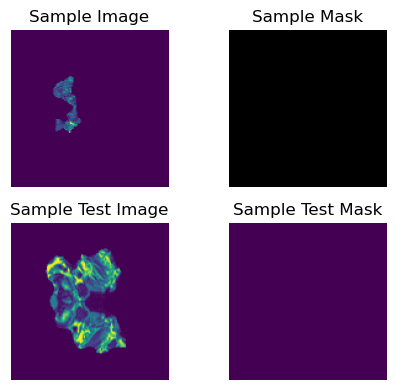

In [6]:
plt.figure(figsize=(6,4))
plt.subplot(2,2,1)
plt.imshow(training_images[0])
plt.title("Sample Image")
plt.axis('off')
plt.tight_layout()
plt.subplot(2,2,2)
plt.imshow(training_masks[0], cmap='gray')
plt.title("Sample Mask")
plt.axis('off')
plt.tight_layout()
plt.subplot(2,2,3)
plt.imshow(test_images[0])
plt.title("Sample Test Image")
plt.axis('off')
plt.tight_layout()
plt.subplot(2,2,4)
plt.imshow(test_masks[0])
plt.title("Sample Test Mask")
plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
train_images_norm = normalize_image(training_images, method='minmax')
test_images_norm = normalize_image(test_images, method='minmax')

In [8]:
X_train = train_images_norm.reshape(-1, 1)  # Pixel intensities
y_train = training_masks.reshape(-1)     # Binary labels (0 or 1)
X_test = test_images_norm.reshape(-1, 1)  # Pixel intensities
y_test = test_masks.reshape(-1)     # Binary labels (0 or 1)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Counts of unique values in y_train: {np.unique(y_train, return_counts=True)}")

Shape of X_train: (30261248, 1)
Shape of y_train: (30261248,)
Shape of X_test: (15515648, 1)
Shape of y_test: (15515648,)
Counts of unique values in y_train: (array([0., 1.], dtype=float32), array([30092814,   168434]))


In [8]:
clf = GaussianNB()
clf.fit(X_train, y_train)


,priors,None
,var_smoothing,1e-09


In [52]:
X_test = test_images_norm.reshape(-1, 1)
y_pred = clf.predict(X_test)
predicted_masks = y_pred.reshape(test_images.shape)
print(f"predicted masks shape {predicted_masks.shape}")

predicted masks shape (947, 128, 128)


In [9]:
def dice_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred) # Element-wise multiplication and sum. If y_true and y_pred are binary masks, this gives the number of pixels that are predicted as positive and are actually positive.
    total = np.sum(y_true) + np.sum(y_pred) # total number of positive pixels in both masks
    if total == 0:
        return 1.0  
    return 2. * intersection / total

def lesion_wise_accuracy(y_true, y_pred):
    true_lesions = np.unique(y_true) # Unique lesion labels in the true mask.
    pred_lesions = np.unique(y_pred) # Unique lesion labels in the predicted mask
    
    true_lesions = true_lesions[true_lesions != 0] # Exclude background (0)
    pred_lesions = pred_lesions[pred_lesions != 0] 
    
    true_positive = 0
    false_negative = len(true_lesions)
    false_positive = len(pred_lesions)
    
    for lesion in true_lesions:
        if lesion in pred_lesions:
            true_positive += 1
            false_negative -= 1
            false_positive -= 1
    
    if (true_positive + false_negative) == 0:
        sensitivity = 1.0
    else:
        sensitivity = true_positive / (true_positive + false_negative) # Recall or Sensitivity
    
    if (true_positive + false_positive) == 0:
        precision = 1.0
    else:
        precision = true_positive / (true_positive + false_positive)
    
    if (precision + sensitivity) == 0:
        f1 = 1.0
    else:
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity) # F1 Score(Lesion wise accuracy)
    
    return f1


In [54]:
# Evaluate on each test sample
dice_scores_nb = []
f1_scores_nb = []
lesion_accuracies_nb = []

for i in range(test_images.shape[0]):
    true = test_masks[i].flatten()
    pred = predicted_masks[i].flatten()
    dice_scores_nb.append(dice_score(true, pred))
    f1 = f1_score(true, pred, zero_division=1)
    f1_scores_nb.append(f1)
    lesion_accuracies_nb.append(lesion_wise_accuracy(test_masks[i], predicted_masks[i]))

print(f"Mean Dice Score for Naive Bayes: {np.mean(dice_scores_nb):.4f}")
print(f"Mean F1 Score for Naive Bayes: {np.mean(f1_scores_nb):.4f}")
print(f"Mean Lesion-wise Accuracy for Naive Bayes: {np.mean(lesion_accuracies_nb):.4f}")

Mean Dice Score for Naive Bayes: 0.5016
Mean F1 Score for Naive Bayes: 0.5016
Mean Lesion-wise Accuracy for Naive Bayes: 0.5016


### K-Nearest Neighbour

In [11]:
# from sklearn.neighbors import KNeighborsClassifier
# knn = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
# knn.fit(X_train, y_train)
# y_pred_knn = knn.predict(X_test)


In [25]:
# dice_scores_knn = []
# f1_scores_knn = []
# lesion_accuracies_knn = []
# predicted_masks_knn = y_pred_knn.reshape(test_images.shape)
# for i in range(test_images.shape[0]):
#     true = test_masks[i].flatten()
#     pred = predicted_masks_knn[i].flatten()
#     dice_scores_knn.append(dice_score(true, pred))
#     f1 = f1_score(true, pred, zero_division=1)
#     f1_scores_knn.append(f1)
#     lesion_accuracies_knn.append(lesion_wise_accuracy(test_masks[i], predicted_masks_knn[i]))

### Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [ ]:
dice_scores_rf = []
f1_scores_rf = []
lesion_accuracies_rf = []
predicted_masks_rf = y_pred_rf.reshape(test_images.shape)
for i in range(test_images.shape[0]):
    true = test_masks[i].flatten()
    pred = predicted_masks_rf[i].flatten()
    dice_scores_rf.append(dice_score(true, pred))
    f1 = f1_score(true, pred, zero_division=1)
    f1_scores_rf.append(f1)
    lesion_accuracies_rf.append(lesion_wise_accuracy(test_masks[i], predicted_masks_rf[i]))

### U-net

In [10]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self,x):
        return self.conv_op(x)
    

In [11]:
class DownSample(nn.Module):
    def  __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)
        return down, p

In [12]:
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2 , kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels,out_channels)
    
    def forward(self,x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1,x2],dim=1)
        return self.conv(x)

In [13]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64,out_channels=num_classes, kernel_size=1)
    
    def forward(self,x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)

        up_1 = self.up_convolution_1(b,down_4)
        up_2 = self.up_convolution_2(up_1,down_3)
        up_3 = self.up_convolution_3(up_2,down_2)
        up_4 = self.up_convolution_4(up_3,down_1)

        out = self.out(up_4)
        return out

In [14]:
train_images_tensor = torch.tensor(train_images_norm, dtype=torch.float32).unsqueeze(1)
train_masks_tensor = torch.tensor(training_masks, dtype=torch.float32).unsqueeze(1)
test_images_tensor = torch.tensor(test_images_norm, dtype=torch.float32).unsqueeze(1)
test_masks_tensor = torch.tensor(test_masks, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(train_images_tensor, train_masks_tensor)
test_dataset = TensorDataset(test_images_tensor, test_masks_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
# Training loop
def trainer_class(model, train_loader, test_loader, criterion, optimizer, num_epochs, device, patience_counter, scheduler=None):
    training_losses = []
    validation_losses = []
    best_val_loss = float('inf')
    train_dice_scores = []
    valid_dice_scores = []
    patience = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        validation_loss = 0.0
        dice = 0.0
        for batch_idx, (images, masks) in enumerate(tqdm.tqdm(train_loader, desc=f"Train Epoch {epoch+1}/{num_epochs}")):
            images, masks = images.to(device, dtype=torch.float32), masks.to(device, dtype=torch.float32)
            optimizer.zero_grad()
            outputs = model(images) #logits 
            # print(f"masks shape: {masks.shape}, outputs shape: {outputs.shape}")
            loss = criterion(outputs, masks)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            preds = outputs > 0.5
            train_loss += loss.item() * images.size(0)
            dice+= dice_score(masks.cpu().numpy(), preds.cpu().numpy())
        epoch_train_loss = train_loss / len(train_loader.dataset)
        training_losses.append(epoch_train_loss)
        epoch_dice_score = dice / len(train_loader.dataset)
        train_dice_scores.append(epoch_dice_score)
        # Validation
        model.eval()
        with torch.no_grad():
            for images, masks in tqdm.tqdm(test_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                # print(f"masks shape: {masks.shape}, outputs shape: {outputs.shape}")
                loss = criterion(outputs, masks)
                validation_loss += loss.item() * images.size(0)
                dice += dice_score(masks.cpu().numpy(), (outputs > 0.5).cpu().numpy())
        epoch_val_loss = validation_loss / len(test_loader.dataset)
        validation_losses.append(epoch_val_loss)
        epoch_dice_score_val = dice / len(test_loader.dataset)
        valid_dice_scores.append(epoch_dice_score_val)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience = 0
        else:
            patience += 1
        if patience >= patience_counter:
            print("Early stopping triggered")
            break
        if scheduler:
            scheduler.step(epoch_val_loss)
    return training_losses, validation_losses, train_dice_scores, valid_dice_scores

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, num_classes=1)
model = model.to(device)
criterion_bce = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
num_epochs = 50
patience_counter = 5

In [29]:
training_losses, validation_losses, train_dice_scores, valid_dice_scores = trainer_class(model, train_loader, test_loader, criterion_bce, optimizer, num_epochs, device, patience_counter)

Validation Epoch 1/50: 100%|██████████| 30/30 [00:02<00:00, 14.00it/s]


Epoch 1/50, Train Loss: 0.3343, Val Loss: 0.0472


Validation Epoch 2/50: 100%|██████████| 30/30 [00:01<00:00, 18.95it/s]


Epoch 2/50, Train Loss: 0.0324, Val Loss: 0.0329


Validation Epoch 3/50: 100%|██████████| 30/30 [00:01<00:00, 16.72it/s]


Epoch 3/50, Train Loss: 0.0280, Val Loss: 0.0311


Validation Epoch 4/50: 100%|██████████| 30/30 [00:01<00:00, 17.13it/s]


Epoch 4/50, Train Loss: 0.0261, Val Loss: 0.0288


Validation Epoch 5/50: 100%|██████████| 30/30 [00:01<00:00, 15.75it/s]


Epoch 5/50, Train Loss: 0.0224, Val Loss: 0.0284


Validation Epoch 6/50: 100%|██████████| 30/30 [00:01<00:00, 17.40it/s]


Epoch 6/50, Train Loss: 0.0191, Val Loss: 0.0238


Validation Epoch 7/50: 100%|██████████| 30/30 [00:01<00:00, 17.51it/s]


Epoch 7/50, Train Loss: 0.0174, Val Loss: 0.0235


Validation Epoch 8/50: 100%|██████████| 30/30 [00:01<00:00, 17.77it/s]


Epoch 8/50, Train Loss: 0.0159, Val Loss: 0.0196


Validation Epoch 9/50: 100%|██████████| 30/30 [00:01<00:00, 15.75it/s]


Epoch 9/50, Train Loss: 0.0146, Val Loss: 0.0265


Validation Epoch 10/50: 100%|██████████| 30/30 [00:01<00:00, 15.10it/s]


Epoch 10/50, Train Loss: 0.0147, Val Loss: 0.0230


Validation Epoch 11/50: 100%|██████████| 30/30 [00:01<00:00, 16.22it/s]


Epoch 11/50, Train Loss: 0.0142, Val Loss: 0.0194


Validation Epoch 12/50: 100%|██████████| 30/30 [00:01<00:00, 17.38it/s]


Epoch 12/50, Train Loss: 0.0126, Val Loss: 0.0171


Validation Epoch 13/50: 100%|██████████| 30/30 [00:01<00:00, 17.42it/s]


Epoch 13/50, Train Loss: 0.0113, Val Loss: 0.0184


Validation Epoch 14/50: 100%|██████████| 30/30 [00:01<00:00, 16.80it/s]


Epoch 14/50, Train Loss: 0.0110, Val Loss: 0.0152


Validation Epoch 15/50: 100%|██████████| 30/30 [00:01<00:00, 17.68it/s]


Epoch 15/50, Train Loss: 0.0099, Val Loss: 0.0153


Validation Epoch 16/50: 100%|██████████| 30/30 [00:01<00:00, 16.25it/s]


Epoch 16/50, Train Loss: 0.0089, Val Loss: 0.0129


Validation Epoch 17/50: 100%|██████████| 30/30 [00:01<00:00, 15.90it/s]


Epoch 17/50, Train Loss: 0.0087, Val Loss: 0.0127


Validation Epoch 18/50: 100%|██████████| 30/30 [00:01<00:00, 16.21it/s]


Epoch 18/50, Train Loss: 0.0083, Val Loss: 0.0117


Validation Epoch 19/50: 100%|██████████| 30/30 [00:01<00:00, 17.15it/s]


Epoch 19/50, Train Loss: 0.0076, Val Loss: 0.0119


Validation Epoch 20/50: 100%|██████████| 30/30 [00:01<00:00, 17.23it/s]


Epoch 20/50, Train Loss: 0.0074, Val Loss: 0.0117


Validation Epoch 21/50: 100%|██████████| 30/30 [00:01<00:00, 17.87it/s]


Epoch 21/50, Train Loss: 0.0076, Val Loss: 0.0124


Validation Epoch 22/50: 100%|██████████| 30/30 [00:01<00:00, 15.00it/s]


Epoch 22/50, Train Loss: 0.0074, Val Loss: 0.0111


Validation Epoch 23/50: 100%|██████████| 30/30 [00:01<00:00, 15.52it/s]


Epoch 23/50, Train Loss: 0.0072, Val Loss: 0.0118


Validation Epoch 24/50: 100%|██████████| 30/30 [00:01<00:00, 16.92it/s]


Epoch 24/50, Train Loss: 0.0077, Val Loss: 0.0111


Validation Epoch 25/50: 100%|██████████| 30/30 [00:01<00:00, 16.58it/s]


Epoch 25/50, Train Loss: 0.0068, Val Loss: 0.0142


Validation Epoch 26/50: 100%|██████████| 30/30 [00:01<00:00, 17.72it/s]


Epoch 26/50, Train Loss: 0.0068, Val Loss: 0.0106


Validation Epoch 27/50: 100%|██████████| 30/30 [00:01<00:00, 22.79it/s]


Epoch 27/50, Train Loss: 0.0063, Val Loss: 0.0109


Validation Epoch 28/50: 100%|██████████| 30/30 [00:01<00:00, 16.61it/s]


Epoch 28/50, Train Loss: 0.0063, Val Loss: 0.0108


Validation Epoch 29/50: 100%|██████████| 30/30 [00:01<00:00, 15.43it/s]


Epoch 29/50, Train Loss: 0.0060, Val Loss: 0.0127


Validation Epoch 30/50: 100%|██████████| 30/30 [00:01<00:00, 17.93it/s]


Epoch 30/50, Train Loss: 0.0061, Val Loss: 0.0110


Validation Epoch 31/50: 100%|██████████| 30/30 [00:01<00:00, 15.21it/s]


Epoch 31/50, Train Loss: 0.0059, Val Loss: 0.0106


Validation Epoch 32/50: 100%|██████████| 30/30 [00:01<00:00, 15.84it/s]


Epoch 32/50, Train Loss: 0.0058, Val Loss: 0.0112


Validation Epoch 33/50: 100%|██████████| 30/30 [00:01<00:00, 21.90it/s]


Epoch 33/50, Train Loss: 0.0057, Val Loss: 0.0118


Validation Epoch 34/50: 100%|██████████| 30/30 [00:01<00:00, 15.13it/s]


Epoch 34/50, Train Loss: 0.0055, Val Loss: 0.0114


Validation Epoch 35/50: 100%|██████████| 30/30 [00:01<00:00, 17.04it/s]


Epoch 35/50, Train Loss: 0.0054, Val Loss: 0.0105


Validation Epoch 36/50: 100%|██████████| 30/30 [00:01<00:00, 17.21it/s]


Epoch 36/50, Train Loss: 0.0053, Val Loss: 0.0105


Validation Epoch 37/50: 100%|██████████| 30/30 [00:01<00:00, 16.73it/s]


Epoch 37/50, Train Loss: 0.0054, Val Loss: 0.0108


Validation Epoch 38/50: 100%|██████████| 30/30 [00:01<00:00, 17.81it/s]


Epoch 38/50, Train Loss: 0.0053, Val Loss: 0.0109


Validation Epoch 39/50: 100%|██████████| 30/30 [00:01<00:00, 19.24it/s]


Epoch 39/50, Train Loss: 0.0051, Val Loss: 0.0112


Validation Epoch 40/50: 100%|██████████| 30/30 [00:02<00:00, 13.86it/s]

Epoch 40/50, Train Loss: 0.0054, Val Loss: 0.0115
Early stopping triggered


In [30]:
def plot_losses(training_losses, validation_losses):
    plt.figure(figsize=(8,5))
    plt.plot(training_losses, marker='o', label="Training Loss")
    plt.plot(validation_losses, marker='s', label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.title("Training and Validation Loss over Epochs")
    plt.legend()
    plt.show()

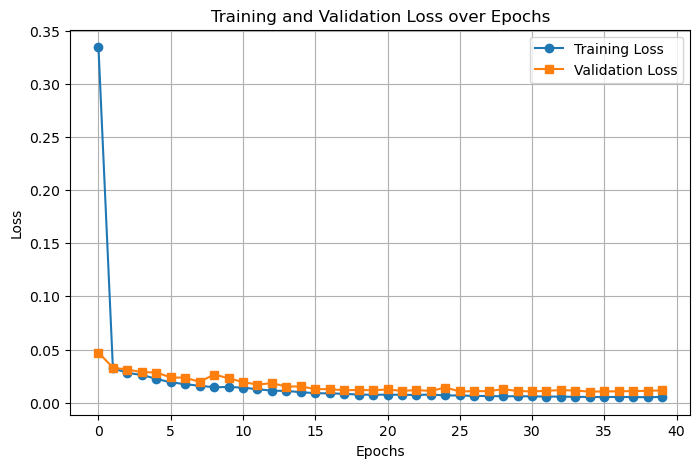

In [52]:
plot_losses(training_losses, validation_losses)

In [31]:
def evaluate_model(model, test_loader, device, threshold):
    model.eval()
    dice_scores = []
    f1_scores = []
    lesion_accuracies = []
    all_preds = []
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > threshold  # Binarize predictions
            all_preds.append(preds.cpu().numpy())
            for i in range(images.size(0)):
                true = masks[i].cpu().numpy().flatten()
                pred = preds[i].cpu().numpy().flatten()
                dice_scores.append(dice_score(true, pred))
                f1 = f1_score(true, pred, zero_division=1)
                f1_scores.append(f1)
                lesion_accuracies.append(lesion_wise_accuracy(masks[i].cpu().numpy(), preds[i].cpu().numpy()))
    return dice_scores, f1_scores, lesion_accuracies, np.concatenate(all_preds, axis=0)

In [46]:
train_dice_scores, f1_scores, lesion_accuracies, preds = evaluate_model(model, test_loader, device, threshold=0.51)

In [47]:
print(f"Mean Dice Score for U-Net: {np.mean(train_dice_scores):.4f}")
print(f"Mean F1 Score for U-Net: {np.mean(f1_scores):.4f}")
print(f"Mean Lesion-wise Accuracy for U-Net: {np.mean(lesion_accuracies):.4f}")

Mean Dice Score for U-Net: 0.7107
Mean F1 Score for U-Net: 0.7107
Mean Lesion-wise Accuracy for U-Net: 0.8881


In [48]:
unet_predicted_masks = preds.reshape(test_images.shape)
unet_predicted_masks.shape

(947, 128, 128)

In [49]:
def plot_sample_predictions(test_images, test_masks, unet_predicted_masks,title, num_sample=3):
    num_sample = 3
    idx = 20
    plt.figure(figsize=(12,8))
    for i in range(num_sample):
        plt.subplot(num_sample, 3, i*3 + 1)
        plt.imshow(test_images[idx + i], cmap='gray')
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(num_sample, 3, i*3 + 2)
        plt.imshow(test_masks[idx + i], cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        plt.subplot(num_sample, 3, i*3 + 3)
        plt.imshow(unet_predicted_masks[idx + i], cmap='gray')
        plt.title("title")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


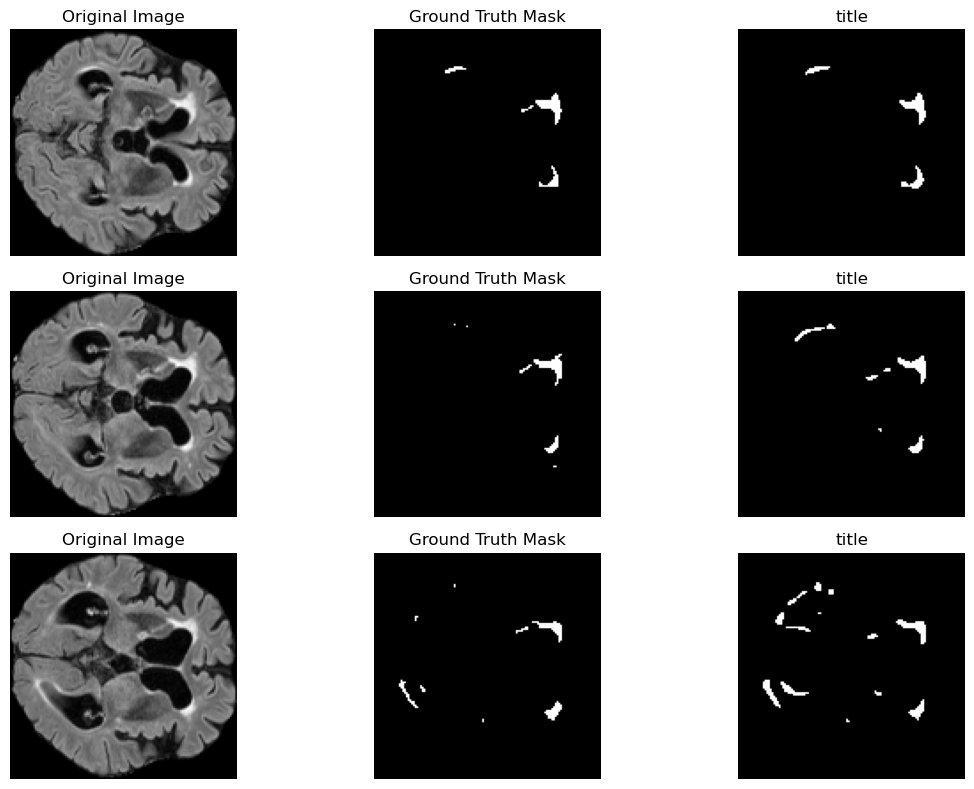

In [51]:
plot_sample_predictions(test_images, test_masks, unet_predicted_masks,title="UNet Segmentation", num_sample=3)

### Experiment 2
#### Train the model using a combination of Dice loss and weighted Cross-Entropy loss

In [20]:
def dice_loss(preds, targets, threshold, smooth=1):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum(dim=(2,3))
    total = preds.sum(dim=(2,3)) + targets.sum(dim=(2,3))
    dice = (2. * intersection + smooth) / (total + smooth)
    loss = 1 - dice
    return loss.mean()

In [21]:
from sklearn.utils import class_weight
labels = training_masks.flatten()
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(f"Class Weights: {class_weights}")
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"class weights dict: {class_weights_dict}")
pos_weight = class_weights[1] / class_weights[0]
pos_weight = pos_weight.to(device)
print(f"Positive class weight for Cross-Entropy Loss: {pos_weight}")

Class Weights: tensor([ 0.5028, 89.8312], device='cuda:0')
class weights dict: {0: tensor(0.5028, device='cuda:0'), 1: tensor(89.8312, device='cuda:0')}
Positive class weight for Cross-Entropy Loss: 178.662353515625


In [22]:
def combined_loss(preds, targets, class_weights):
    bce_loss = nn.BCEWithLogitsLoss(weight=pos_weight)(preds, targets)
    dice_loss_val = dice_loss(preds, targets, threshold=0.5)
    return bce_loss + dice_loss_val

In [64]:
criterion = lambda preds, targets: combined_loss(preds, targets, pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
num_epochs = 50
patience_counter = 7

In [ ]:
training_losses, validation_losses, train_dice_scores, valid_dice_scores = trainer_class(model, train_loader, test_loader, criterion, optimizer, num_epochs, device, patience_counter, scheduler=None)

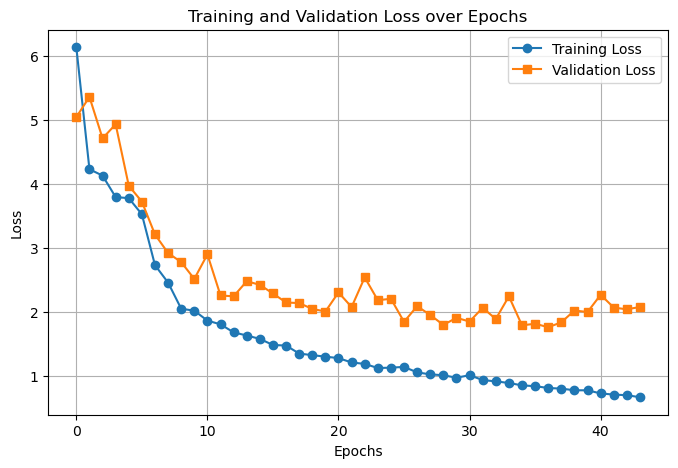

In [66]:
plot_losses(training_losses, validation_losses)

In [67]:
train_dice_scores, f1_scores, lesion_accuracies, preds = evaluate_model(model, test_loader, device, threshold=0.5)
print(f"Mean Dice Score: {np.mean(train_dice_scores):.4f}")
print(f"Mean F1 Score: {np.mean(f1_scores):.4f}")
print(f"Mean Lesion-wise Accuracy: {np.mean(lesion_accuracies):.4f}")


Mean Dice Score: 0.7532
Mean F1 Score: 0.7532
Mean Lesion-wise Accuracy: 0.9187


In [ ]:
plot_sample_predictions(test_images, test_masks, preds.reshape(test_images.shape), num_sample=3)

## Experiment 3
### Learning Rate Scheduler

In [24]:
criterion = lambda preds, targets: combined_loss(preds, targets, pos_weight)
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)
num_epochs = 50
patience_counter = 10
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience=5, factor=0.1)

In [ ]:
training_losses, validation_losses, train_dice_scores, valid_dice_scores = trainer_class(model, train_loader, test_loader, criterion, optimizer, num_epochs, device, patience_counter, scheduler=scheduler)

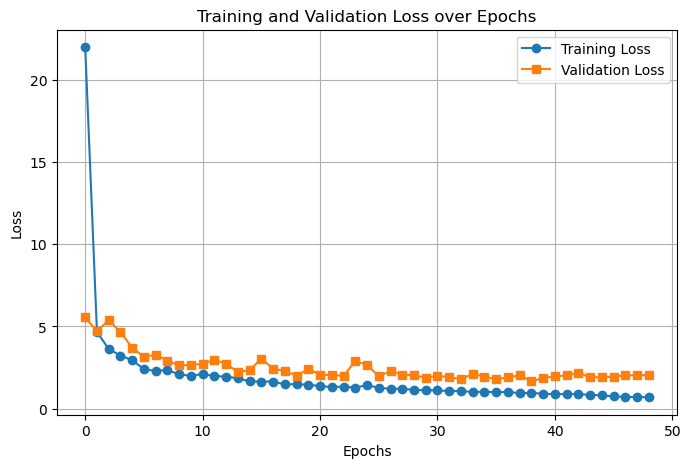

In [26]:
plot_losses(training_losses, validation_losses)

In [27]:
train_dice_scores, f1_scores, lesion_accuracies, preds = evaluate_model(model, test_loader, device, threshold=0.30)
print(f"Mean Dice Score: {np.mean(train_dice_scores):.4f}")
print(f"Mean F1 Score: {np.mean(f1_scores):.4f}")
print(f"Mean Lesion-wise Accuracy: {np.mean(lesion_accuracies):.4f}")

Mean Dice Score: 0.7648
Mean F1 Score: 0.7648
Mean Lesion-wise Accuracy: 0.9303
